In [285]:
import pymongo
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


from nltk.corpus import brown
from nltk.corpus import reuters 
from nltk.corpus import stopwords


from nltk.probability import FreqDist
from nltk.stem import WordNetLemmatizer
from nltk.stem import SnowballStemmer 

from nltk.tokenize import RegexpTokenizer

from tqdm import tqdm

In [30]:
client = pymongo.Connection()
collection = client.politics.debates

In [259]:
sb = SnowballStemmer("english")
wn_lem = WordNetLemmatizer()
tokenizer = RegexpTokenizer("[\w']+")

In [216]:
stops = stopwords.words('english')
stops = stops + ["don't", "didn't", "that", "mr", "i'm", "us", "would","one", "two"]

In [135]:
def stemWords(l):
    return([sb.stem(x) for x in l if x not in stops and len(x) > 2])

In [207]:
snowballed = [sb.stem(x) for x in reuters.words() if x not in stops and len(x) > 2]
wordnetted = [wn.lemmatize(x) for x in reuters.words()]

In [208]:
fd_all = FreqDist(snowballed)

In [206]:
texts = collection.find()
df = pd.DataFrame(list(texts))
df["tokenized"] = df["text"].apply(lambda x: [y.lower() for y in tokenizer.tokenize(x)])
df["stemmed"] = df["tokenized"].apply(stemWords)
df["lemmatized"] = df["tokenized"].apply(lambda l: [wn.lemmatize(x) for x in l if x not in stops and len(x) > 2])

In [209]:
df.head()

,_id,days_after,debate,newspaper,text,title,word_count,year,tokenized,stemmed,lemmatized
0,1,0,1,Washington Post,EIGHT Questions\nWhat's at stake in the first ...,EIGHT Questions,2215,2012,"[eight, questions, what's, at, stake, in, the,...","[eight, question, what, stake, first, debat, f...","[eight, question, what's, stake, first, debate..."
1,10,2,1,The International Herald Tribune,﻿\nDebate shakes up presidential race;\nRomney...,Debate shakes up presidential race,1234,2012,"[debate, shakes, up, presidential, race, romne...","[debat, shake, presidenti, race, romney, buoya...","[debate, shake, presidential, race, romney, bu..."
2,100,1,2,The Gazette,﻿\nMore aggressive Obama goes on offensive; Pr...,More aggressive Obama goes on offensive,888,2012,"[more, aggressive, obama, goes, on, offensive,...","[aggress, obama, goe, offens, presid, invok, t...","[aggressive, obama, go, offensive, president, ..."
3,101,1,3,The Telegraph,﻿\nBarack Obama labels Romney reckless in heat...,Barack Obama labels Romney reckless in heated ...,2539,2012,"[barack, obama, labels, romney, reckless, in, ...","[barack, obama, label, romney, reckless, heat,...","[barack, obama, label, romney, reckless, heate..."
4,102,1,3,The Telegraph,White House showdown sees Obama label Mitt Rom...,White House showdown sees Obama label Mitt Rom...,2539,2012,"[white, house, showdown, sees, obama, label, m...","[white, hous, showdown, see, obama, label, mit...","[white, house, showdown, see, obama, label, mi..."


In [210]:
def createFD(l):
    foo = FreqDist(l)
    out = {}
    for key in foo.keys():
        corpus = foo.freq(key)
        reuters_f = fd_all.freq(key)
        out[key] = corpus - reuters_f
    return(out)

In [211]:
df["diffs"] = df.stemmed.apply(createFD)

In [147]:
stemmed_flattened = [word for article in df.stemmed for word in article]
fd_stemmed = FreqDist(stemmed_flattened)

In [148]:
out = []
for key in tqdm(fd_stemmed.keys()):
    corpus = fd_stemmed.freq(key)
    reuters_f = fd_all.freq(key)
    out.append((key, corpus, reuters_f))

In [177]:
output = pd.DataFrame(out, columns = ["word", "debate_freq", "reuters_freq"])
output["diff"] = output["debate_freq"]-output["reuters_freq"]

In [178]:
output.sort("diff", ascending=0)[:50]

,word,debate_freq,reuters_freq,diff
3810,romney,0.034555,0.000000,0.034555
5113,obama,0.031553,0.000000,0.031553
4586,debat,0.018774,0.000083,0.018691
642,presid,0.012680,0.000982,0.011698
2561,campaign,0.005838,0.000064,0.005774
5446,polici,0.006773,0.001058,0.005715
700,republican,0.004627,0.000060,0.004567
102,candid,0.004174,0.000028,0.004147
2061,voter,0.004125,0.000002,0.004123
1648,attack,0.004253,0.000284,0.003969


In [132]:
output[output["diff"] > 0.001].sort("diff", ascending=0)["word"].tolist()

['romney',
 'obama',
 'debat',
 'presid',
 'polici',
 'campaign',
 'republican',
 'candid',
 'voter',
 'attack',
 'tax',
 'poll',
 'go',
 'point',
 'mitt',
 'state',
 'time',
 'presidenti',
 'question',
 'plan',
 "''",
 'american',
 'elect',
 'first',
 'night',
 'middl',
 'say',
 'like',
 'vote',
 'one',
 'democrat',
 'foreign',
 'get',
 'peopl',
 'job',
 'governor',
 'back',
 'look',
 'perform',
 'issu',
 'race',
 'women',
 'us',
 'economi',
 'moder',
 'would',
 'make',
 'seem',
 'four',
 'denver',
 'want',
 'show',
 'call',
 'univers',
 'challeng',
 'two',
 'iran',
 'percent',
 'america',
 'support',
 'even',
 'cut',
 'critic',
 'polit',
 'accus',
 'tri',
 'differ',
 'class',
 'win',
 'barack',
 'nation',
 'monday',
 'day',
 'million',
 'need',
 'libya',
 'tuesday',
 'much',
 'take',
 'work',
 'second',
 'big',
 'bush',
 'final',
 'china',
 'come',
 'appear',
 'ohio',
 'moment',
 'aggress',
 'mani',
 'administr',
 'that',
 'wednesday',
 'care',
 'ask',
 'know',
 'israel',
 'war',
 'c

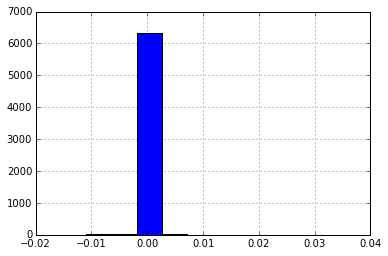

In [127]:
output["diff"].hist()

In [170]:
fd_stemmed.freq("want")/fd_all.freq("want")

4.192178081939275

In [171]:
fd_all.freq("the")

0.01217535335689046

In [172]:
fd_all.freq("want")

0.0005189929328621908

In [165]:
0.004252973143262188/0.00028378975265017667 

14.986352056569018

In [181]:
[x.freq(y) for y in x.keys()]

[0.002425222312045271,
 0.0008084074373484236,
 0.0008084074373484236,
 0.0008084074373484236,
 0.0008084074373484236,
 0.002425222312045271,
 0.004042037186742118,
 0.0016168148746968471,
 0.0016168148746968471,
 0.0008084074373484236,
 0.0008084074373484236,
 0.0008084074373484236,
 0.0008084074373484236,
 0.0008084074373484236,
 0.005658852061438965,
 0.0008084074373484236,
 0.0008084074373484236,
 0.0008084074373484236,
 0.0016168148746968471,
 0.0008084074373484236,
 0.0016168148746968471,
 0.0016168148746968471,
 0.0008084074373484236,
 0.0008084074373484236,
 0.0016168148746968471,
 0.004042037186742118,
 0.0008084074373484236,
 0.0016168148746968471,
 0.004042037186742118,
 0.0008084074373484236,
 0.0016168148746968471,
 0.0016168148746968471,
 0.0008084074373484236,
 0.0008084074373484236,
 0.0008084074373484236,
 0.0008084074373484236,
 0.0008084074373484236,
 0.0008084074373484236,
 0.002425222312045271,
 0.0008084074373484236,
 0.0008084074373484236,
 0.002425222312045271,


In [195]:
df.diffs[1]['attack']

0.001210978558261632

In [190]:
sb.stem("attacking")

'attack'

In [191]:
df.stemmed[0]

['eight',
 'question',
 'what',
 'stake',
 'first',
 'debat',
 'first',
 'debat',
 'usual',
 'attract',
 'biggest',
 'audienc',
 'presid',
 'obama',
 'republican',
 'nomine',
 'mitt',
 'romney',
 'high',
 'stake',
 'event',
 'it',
 'clear',
 'much',
 'bigger',
 'romney',
 'race',
 'remain',
 'close',
 'number',
 'nation',
 'poll',
 'includ',
 'latest',
 'washington',
 'post',
 'abc',
 'news',
 'survey',
 'show',
 'obama',
 'ahead',
 'percent',
 'percent',
 'among',
 'like',
 'voter',
 'recent',
 'survey',
 'mani',
 'battleground',
 'state',
 'indic',
 'obama',
 'larger',
 'lead',
 'republican',
 'strategist',
 'brett',
 "o'donnel",
 'note',
 'campaign',
 'compet',
 'small',
 'slice',
 'undecid',
 'voter',
 'swing',
 'state',
 'frame',
 'open',
 'debat',
 'way',
 'mitt',
 'romney',
 'convinc',
 'voter',
 'presid',
 'obama',
 'blame',
 'present',
 'econom',
 'condit',
 'thing',
 'get',
 'wors',
 'presid',
 'obama',
 'convinc',
 'voter',
 "we'r",
 'head',
 'right',
 'direct',
 'chang',
 '

In [199]:
for row in df.diffs:
    print([x for x in row.keys() if row[x]>0])

['case', 'among', 'what', 'victim', 'realli', 'wors', 'must', 'look', 'ensur', 'eight', 'revert', 'shillelagh', 'particular', 'deft', 'machinist', 'wednesday', 'ticket', 'mae', 'execut', 'battleground', 'director', 'defens', 'fail', 'thing', 'resembl', 'tack', 'one', 'ask', 'channel', 'ago', 'experi', "he'll", 'field', 'endang', 'step', 'percent', 'aerospac', 'make', 'murphi', 'featur', 'pick', 'head', 'like', 'nixon', 'swing', 'ever', 'that', 'big', 'exchang', 'think', 'devin', 'mister', 'biggest', 'fragil', 'strategi', 'came', 'perri', 'latest', 'suggest', 'alan', 'galen', 'palin', 'joel', 'seem', 'turn', 'professor', 'stage', 'brief', 'reagan', 'emerg', 'robust', 'scholar', 'wisconsin', 'knowledg', 'suffer', 'describ', 'peopl', 'top', 'blame', 'number', 'connect', 'refer', 'stagger', 'beyond', 'televis', 'temporarili', 'eager', 'aggress', 'echo', 'watch', 'economi', 'popkin', 'even', 'dougla', 'want', 'mac', 'took', 'button', 'pollster', 'divid', 'smile', 'honest', 'let', 'victori',

In [213]:
def top_ten(d):
    s = sorted(d, key=d.get)
    s = [x for x in s if x not in stops]
    return s[:10]

In [219]:
print(df.diffs[].apply(top_ten))

AttributeError: 'dict' object has no attribute 'apply'

In [221]:
top_ten(df.diffs[1])

['said',
 'year',
 'note',
 'may',
 'first',
 'last',
 'exchang',
 'tax',
 'countri',
 'foreign']

In [222]:
out = []
for row in df.diffs:
    out += ([x for x in row.keys() if row[x]>0])

In [223]:
out

['case',
 'among',
 'what',
 'victim',
 'realli',
 'wors',
 'must',
 'look',
 'ensur',
 'eight',
 'revert',
 'shillelagh',
 'particular',
 'deft',
 'machinist',
 'wednesday',
 'ticket',
 'mae',
 'execut',
 'battleground',
 'director',
 'defens',
 'fail',
 'thing',
 'resembl',
 'tack',
 'one',
 'ask',
 'channel',
 'ago',
 'experi',
 "he'll",
 'field',
 'endang',
 'step',
 'percent',
 'aerospac',
 'make',
 'murphi',
 'featur',
 'pick',
 'head',
 'like',
 'nixon',
 'swing',
 'ever',
 'that',
 'big',
 'exchang',
 'think',
 'devin',
 'mister',
 'biggest',
 'fragil',
 'strategi',
 'came',
 'perri',
 'latest',
 'suggest',
 'alan',
 'galen',
 'palin',
 'joel',
 'seem',
 'turn',
 'professor',
 'stage',
 'brief',
 'reagan',
 'emerg',
 'robust',
 'scholar',
 'wisconsin',
 'knowledg',
 'suffer',
 'describ',
 'peopl',
 'top',
 'blame',
 'number',
 'connect',
 'refer',
 'stagger',
 'beyond',
 'televis',
 'temporarili',
 'eager',
 'aggress',
 'echo',
 'watch',
 'economi',
 'popkin',
 'even',
 'dougla

In [225]:
from collections import Counter

In [226]:
Counter(out)

Counter({'romney': 150, 'debat': 150, 'obama': 150, 'presid': 149, 'mitt': 149, 'republican': 144, 'polici': 137, 'candid': 134, 'campaign': 134, 'american': 130, 'time': 129, 'attack': 129, 'point': 128, 'presidenti': 128, 'poll': 127, 'elect': 123, 'voter': 123, 'back': 122, 'night': 119, 'four': 119, 'like': 117, 'perform': 116, 'say': 114, 'moder': 114, 'question': 112, 'get': 112, 'go': 111, 'show': 110, 'take': 110, 'economi': 109, 'first': 109, 'make': 109, 'issu': 108, 'governor': 106, 'job': 106, 'day': 106, 'race': 105, 'peopl': 103, 'call': 103, 'middl': 103, 'look': 103, 'even': 102, 'state': 101, 'democrat': 101, 'challeng': 99, 'barack': 98, 'tri': 98, 'made': 97, 'support': 97, 'much': 96, 'one': 96, 'come': 95, 'want': 95, 'univers': 93, 'second': 92, 'need': 92, 'mani': 92, 'plan': 90, 'chang': 90, 'seem': 90, 'ask': 90, 'it': 90, 'differ': 89, 'well': 89, 'use': 88, 'final': 88, 'econom': 88, 'critic': 87, 'aggress': 87, 'talk': 87, 'polit': 86, 'turn': 86, 'work': 85

In [227]:
 from nltk.util import ngrams 

In [242]:
Counter(list(ngrams((df.stemmed[2]),2))).most_common()

[(('elector', 'colleg'), 5),
 (('colleg', 'vote'), 4),
 (('five', 'point'), 3),
 (('mitt', 'romney'), 3),
 (('point', 'plan'), 3),
 (('nation', 'poll'), 3),
 (('town', 'hall'), 3),
 (('vote', 'state'), 3),
 (('lead', 'obama'), 2),
 (('foreign', 'polici'), 2),
 (('popular', 'vote'), 2),
 (('barack', 'obama'), 2),
 (('want', 'take'), 2),
 (('swing', 'state'), 2),
 (('romney', 'said'), 2),
 (('state', 'ohio'), 2),
 (('gov', 'romney'), 2),
 (('long', 'island'), 2),
 (('countri', 'need'), 2),
 (('sever', 'conserv'), 2),
 (('denver', 'debat'), 2),
 (('invok', 'theme'), 2),
 (('show', 'obama'), 2),
 (('said', "isn't"), 1),
 (('state', 'democrat'), 1),
 (('ad', 'romney'), 1),
 (('old', 'school'), 1),
 (('number', 'favour'), 1),
 (('debat', 'hofstra'), 1),
 (('difficult', 'direct'), 1),
 (('florida', 'candid'), 1),
 (('spectacular', 'perform'), 1),
 (('struggl', 'economi'), 1),
 (('theme', 'honesti'), 1),
 (('california', 'elector'), 1),
 (('said', 'ad'), 1),
 (('win', 'white'), 1),
 (('vote', 

In [241]:
df.title[2]

'More aggressive Obama goes on offensive'

In [244]:
print(df.text[2])

﻿
More aggressive Obama goes on offensive; President invokes themes of honesty,
integrity as he calls out Mitt Romney
A more forceful and assertive U.S. President Barack Obama emerged from the ashes
of his Denver debacle Tuesday in a town hall-style debate dominated by questions
about the country's struggling economy, national security and its
trillion-dollar budget deficits.
Obama appeared more at ease than he was in the Denver debate where his handlers
claim he was caught off guard by Republican rival Mitt Romney and his sudden
conversion from a self-proclaimed "severe conservative" to the middle ground.
In this debate at Hofstra University in Long Island, Obama aggressively called
out Romney for major policy flip-flops and in so doing indirectly invoked the
themes of integrity and honesty before an estimated television audience of more
than  million people. Missed opportunities to counter his rival in Denver were
not missed in Long Island.
When the first questioner asked what his pr

In [274]:
from textblob import TextBlob 

In [292]:
blob = TextBlob(df.text[130])

In [282]:
blob.noun_phrases 

WordList(['obama'])

In [283]:
for sentence in blob.sentences:
    print(sentence.sentiment.polarity)


0.5


In [279]:
nltk.download("punkt")

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/tillbergmann/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [284]:
blob

TextBlob("More aggressive Obama goes on offensive")

In [331]:
out = []
for text in df.title:
    blob = TextBlob(text)
    x = np.mean([sentence.sentiment.polarity for sentence in blob.sentences])
    out.append(x)

(array([  1.,   2.,   9.,  22.,  97.,   8.,   3.,   4.,   3.,   1.]),
 array([-0.7 , -0.53, -0.36, -0.19, -0.02,  0.15,  0.32,  0.49,  0.66,
         0.83,  1.  ]),
 <a list of 10 Patch objects>)

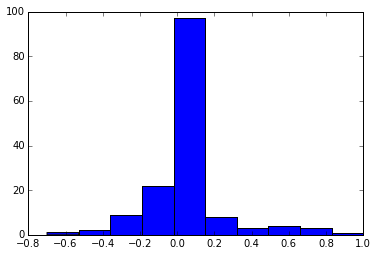

In [333]:
plt.hist(out)

In [332]:
df["sentiment_title"] = pd.Series(out)

In [330]:
del df["sentiment"]

In [354]:
df.head()

,_id,days_after,debate,newspaper,text,title,word_count,year,tokenized,stemmed,lemmatized,diffs,sentiment_text,sentiment_title
0,1,0,1,Washington Post,EIGHT Questions\nWhat's at stake in the first ...,EIGHT Questions,2215,2012,"[eight, questions, what's, at, stake, in, the,...","[eight, question, what, stake, first, debat, f...","[eight, question, what's, stake, first, debate...","{'case': 0.002166830085896861, 'among': 0.0004...",0.139642,0.0
1,10,2,1,The International Herald Tribune,﻿\nDebate shakes up presidential race;\nRomney...,Debate shakes up presidential race,1234,2012,"[debate, shakes, up, presidential, race, romne...","[debat, shake, presidenti, race, romney, buoya...","[debate, shake, presidential, race, romney, bu...","{'fact': 0.0013821358020778864, 'joke': 0.0014...",0.084736,0.0
2,100,1,2,The Gazette,﻿\nMore aggressive Obama goes on offensive; Pr...,More aggressive Obama goes on offensive,888,2012,"[more, aggressive, obama, goes, on, offensive,...","[aggress, obama, goe, offens, presid, invok, t...","[aggressive, obama, go, offensive, president, ...","{'outlin': 0.0018857663427561838, 'recent': 0....",0.098868,0.5
3,101,1,3,The Telegraph,﻿\nBarack Obama labels Romney reckless in heat...,Barack Obama labels Romney reckless in heated ...,2539,2012,"[barack, obama, labels, romney, reckless, in, ...","[barack, obama, label, romney, reckless, heat,...","[barack, obama, label, romney, reckless, heate...","{'case': 0.0004423786217843161, 'bergin': 0.00...",0.025641,0.0
4,102,1,3,The Telegraph,White House showdown sees Obama label Mitt Rom...,White House showdown sees Obama label Mitt Rom...,2539,2012,"[white, house, showdown, sees, obama, label, m...","[white, hous, showdown, see, obama, label, mit...","[white, house, showdown, see, obama, label, mi...","{'case': 0.00044434846253746504, 'bergin': 0.0...",0.025437,0.0


In [315]:
first = df[df["debate"] == 1].copy().reset_index()

In [316]:
first

,index,_id,days_after,debate,newspaper,text,title,word_count,year,tokenized,stemmed,lemmatized,diffs
0,0,1,0,1,Washington Post,EIGHT Questions\nWhat's at stake in the first ...,EIGHT Questions,2215,2012,"[eight, questions, what's, at, stake, in, the,...","[eight, question, what, stake, first, debat, f...","[eight, question, what's, stake, first, debate...","{'case': 0.002166830085896861, 'among': 0.0004..."
1,1,10,2,1,The International Herald Tribune,﻿\nDebate shakes up presidential race;\nRomney...,Debate shakes up presidential race,1234,2012,"[debate, shakes, up, presidential, race, romne...","[debat, shake, presidenti, race, romney, buoya...","[debate, shake, presidential, race, romney, bu...","{'fact': 0.0013821358020778864, 'joke': 0.0014..."
2,12,11,0,1,USA Today,﻿\nWhat voters want in tonight's debate;\nMore...,What voters want in tonight's debate,1734,2012,"[what, voters, want, in, tonight's, debate, mo...","[voter, want, tonight, debat, specif, less, rh...","[voter, want, tonight's, debate, specific, le,...","{'case': 0.0018141466339552169, 'capit': 0.000..."
3,20,26,1,1,The New York Post,\nIt was Mitt Romney's night.\nPolitical analy...,AMERICA'S FUTURE 'Swing' zing for Mitt: pros N...,585,2012,"[it, was, mitt, romney's, night, political, an...","[mitt, romney, night, polit, analyst, four, cr...","[mitt, romney's, night, political, analyst, fo...","{'marquett': 0.0029940119760479044, 'also': 0...."
4,24,12,1,1,The New York Post,America's Future No debating it: Mitt knockout...,America's Future No debating it,952,2012,"[america's, future, no, debating, it, mitt, kn...","[america, futur, debat, mitt, knockout, pound,...","[america's, future, debating, mitt, knockout, ...","{'either': 0.003373430857153466, 'section': 0...."
5,35,13,2,1,The New York Times,﻿\nObama Team Tries to Change Course After Deb...,Obama Team Tries to Change Course After Debate...,1246,2012,"[obama, team, tries, to, change, course, after...","[obama, team, tri, chang, cours, debat, disapp...","[obama, team, try, change, course, debate, dis...","{'capit': 0.000495471527684593, 'signatur': 0...."
6,46,14,1,1,The Globe and Mail,﻿\nShowdown in Denver;\nAn energized Romney ta...,Showdown in Denver,1278,2012,"[showdown, in, denver, an, energized, romney, ...","[showdown, denver, energ, romney, take, fight,...","[showdown, denver, energized, romney, take, fi...","{'among': 0.0028145665562657155, 'rid': 0.0015..."
7,57,15,1,1,Hollywood Reporter,﻿\nObama vs. Romney: What the Pundits Are Sayi...,Obama vs. Romney,1072,2012,"[obama, vs, romney, what, the, pundits, are, s...","[obama, romney, pundit, say, first, debat, vid...","[obama, romney, pundit, saying, first, debate,...","{'capit': 0.0008131396978189351, 'fact': 0.003..."
8,59,16,1,1,El Paso Times,"﻿\nShowdown in Denver: Obama, Romney spar over...",Showdown in Denver,1178,2012,"[showdown, in, denver, obama, romney, spar, ov...","[showdown, denver, obama, romney, spar, econom...","[showdown, denver, obama, romney, spar, econom...","{'rep': 0.002859930671791375, 'rid': 0.0014553..."
9,60,17,1,1,Christian Science Monitor,Presidential debate: Mitt Romney injects new l...,Presidential debate,1004,2012,"[presidential, debate, mitt, romney, injects, ...","[presidenti, debat, mitt, romney, inject, new,...","[presidential, debate, mitt, romney, injects, ...","{'capit': 0.0008101721626536434, 'fact': 0.001..."


In [312]:
first.shape

(50, 12)

In [352]:
for row in first["diffs"]: 
    if "forc" in row.keys():
        print(row["forc"])

0.0003645028437088476
0.0005923648364122374
0.005544119358456233
0.0009316112247923359
0.0032552322744245424
0.001015949420958964
0.0008983772855550548
0.0012227620730270907
0.000771162235036001
0.0008397924538572146
0.0004211473094746109
0.0007284283489161097
0.0013104813712727047
0.001236767675267987
0.000777096627361645
0.0009846668349318525
0.005556095406360424
0.0008045348570470657
0.001187416776670375
0.0009887601628074153
0.001548127278870384
0.0014754812029055295
0.0015803869043361325
0.0007785892938909863


In [322]:
wn.synsets('aggress')[0].hypernym_paths()

[[Synset('act.v.01'), Synset('attack.v.03')]]

In [335]:
df.groupby(["debate", "days_after"]).mean()

_id   word_count  year  sentiment_text  \
debate days_after                                                  
1      0            17.600000  1639.000000  2012        0.102973   
       1            27.357143  1166.785714  2012        0.069267   
       2            24.764706  1204.411765  2012        0.064192   
2      0            78.000000  1044.333333  2012        0.060900   
       1            76.076923  1012.269231  2012        0.078680   
       2            74.428571  1258.380952  2012        0.080658   
3      0           129.750000  1143.916667  2012        0.048740   
       1           123.862069  1243.586207  2012        0.037521   
       2           125.111111  1144.000000  2012        0.052644   

                   sentiment_title  
debate days_after                   
1      0                  0.100000  
       1                  0.052192  
       2                  0.102139  
2      0                  0.350000  
       1                 -0.008217  
       2                  0.027459  
3      0                 -0.039732  
       1                 -0.010057  
       2                 -0.040152

In [346]:
keys = []
for row in df.diffs:
    keys += list(row.keys())

In [348]:
Counter(keys).most_common()

[('romney', 150),
 ('debat', 150),
 ('obama', 150),
 ('presid', 149),
 ('mitt', 149),
 ('republican', 144),
 ('said', 142),
 ('first', 140),
 ('say', 139),
 ('polici', 137),
 ('would', 135),
 ('one', 135),
 ('candid', 134),
 ('campaign', 134),
 ('two', 134),
 ('year', 133),
 ('state', 131),
 ('american', 131),
 ('time', 130),
 ('attack', 129),
 ('point', 128),
 ('presidenti', 128),
 ('poll', 127),
 ('also', 127),
 ('last', 125),
 ('elect', 123),
 ('voter', 123),
 ('back', 122),
 ('night', 119),
 ('four', 119),
 ('like', 117),
 ('perform', 116),
 ('make', 115),
 ('nation', 114),
 ('moder', 114),
 ('plan', 113),
 ('question', 112),
 ('get', 112),
 ('issu', 112),
 ('show', 111),
 ('week', 111),
 ('day', 111),
 ('go', 111),
 ('take', 111),
 ('economi', 109),
 ('governor', 106),
 ('job', 106),
 ('race', 105),
 ('call', 104),
 ('peopl', 103),
 ('middl', 103),
 ('look', 103),
 ('new', 103),
 ('even', 102),
 ('democrat', 101),
 ('could', 100),
 ('made', 100),
 ('challeng', 99),
 ('tax', 98),
 

In [ ]:
agg_words = ["attack", "aggress", "accus", "forc", "battleground", "war", "fight", "weak", "defens", "press","defend"]

In [353]:
df.lemmatized[0]

['eight',
 'question',
 "what's",
 'stake',
 'first',
 'debate',
 'first',
 'debate',
 'usually',
 'attract',
 'biggest',
 'audience',
 'president',
 'obama',
 'republican',
 'nominee',
 'mitt',
 'romney',
 'high',
 'stake',
 'event',
 "it's",
 'clearly',
 'much',
 'bigger',
 'romney',
 'race',
 'remains',
 'close',
 'number',
 'national',
 'poll',
 'including',
 'latest',
 'washington',
 'post',
 'abc',
 'news',
 'survey',
 'showed',
 'obama',
 'ahead',
 'percent',
 'percent',
 'among',
 'likely',
 'voter',
 'recent',
 'survey',
 'many',
 'battleground',
 'state',
 'indicate',
 'obama',
 'larger',
 'lead',
 'republican',
 'strategist',
 'brett',
 "o'donnell",
 'note',
 'campaign',
 'competing',
 'small',
 'slice',
 'undecided',
 'voter',
 'swing',
 'state',
 'framed',
 'opening',
 'debate',
 'way',
 'mitt',
 'romney',
 'convince',
 'voter',
 'president',
 'obama',
 'blame',
 'present',
 'economic',
 'condition',
 'thing',
 'getting',
 'worse',
 'president',
 'obama',
 'convince',
 'vo

In [358]:
df[df.sentiment_title<0].groupby('debate').count()

,_id,days_after,newspaper,text,title,word_count,year,tokenized,stemmed,lemmatized,diffs,sentiment_text,sentiment_title
debate,,,,,,,,,,,,,
1,7,7,7,7,7,7,7,7,7,7,7,7,7
2,6,6,6,6,6,6,6,6,6,6,6,6,6
3,21,21,21,21,21,21,21,21,21,21,21,21,21


In [359]:
df[df.sentiment_text<0].groupby('debate').count()

,_id,days_after,newspaper,text,title,word_count,year,tokenized,stemmed,lemmatized,diffs,sentiment_text,sentiment_title
debate,,,,,,,,,,,,,
3,5,5,5,5,5,5,5,5,5,5,5,5,5
